## Extract timeseries from file

Let us use a lower level interface to extract a timeseries of temperature from a file and plot it.

In [26]:
from netCDF4 import Dataset
from cftime import num2pydate
import numpy as np
from bisect import bisect
import matplotlib
import matplotlib.pyplot as plt

In [19]:
vname = 'tas'

In [2]:
earth_radius = 3958.75
def get_distances(alat,alon,xlat,xlon):
    lat_dif = np.radians(alat - xlat)
    long_dif = np.radians(alon - xlon)
    sin_d_lat = np.sin(lat_dif / 2.)
    sin_d_long = np.sin(long_dif / 2.)
    step_1 = ((sin_d_lat ** 2) + (sin_d_long ** 2) * 
              np.cos(np.radians(alat)) * np.cos(np.radians(xlat)))
    step_2 = 2 * np.arctan2(np.sqrt(step_1), np.sqrt(1-step_1))
    dist = step_2 * earth_radius
    return dist

In [6]:
from ipyfilechooser import FileChooser

fc = FileChooser()
display(fc)

FileChooser(path='/home/netapp-clima/users/ggiulian/Documents/NextCloud/Documents/pwf', filename='', title='',…

In [9]:
fname = fc.selected

# Point latitude=9.83377, longitude=5.6141114
#      Time            temperature (K)
1990-01-01T03:00:00Z   295.24
1990-01-01T06:00:00Z   293.93
1990-01-01T09:00:00Z   303.76
1990-01-01T12:00:00Z   307.54
1990-01-01T15:00:00Z   308.88
1990-01-01T18:00:00Z   299.85
1990-01-01T21:00:00Z   297.28
1990-01-02T00:00:00Z   295.51
1990-01-02T03:00:00Z   294.09
1990-01-02T06:00:00Z   293.00
1990-01-02T09:00:00Z   302.99
1990-01-02T12:00:00Z   306.94
1990-01-02T15:00:00Z   308.51
1990-01-02T18:00:00Z   299.50
1990-01-02T21:00:00Z   296.75
1990-01-03T00:00:00Z   295.51
1990-01-03T03:00:00Z   294.41
1990-01-03T06:00:00Z   293.34
1990-01-03T09:00:00Z   303.41
1990-01-03T12:00:00Z   307.77
1990-01-03T15:00:00Z   309.10
1990-01-03T18:00:00Z   300.65
1990-01-03T21:00:00Z   298.11
1990-01-04T00:00:00Z   297.02
1990-01-04T03:00:00Z   295.87
1990-01-04T06:00:00Z   294.60
1990-01-04T09:00:00Z   304.95
1990-01-04T12:00:00Z   309.15
1990-01-04T15:00:00Z   310.21
1990-01-04T18:00:00Z   302.41
1990-01-04T21:0

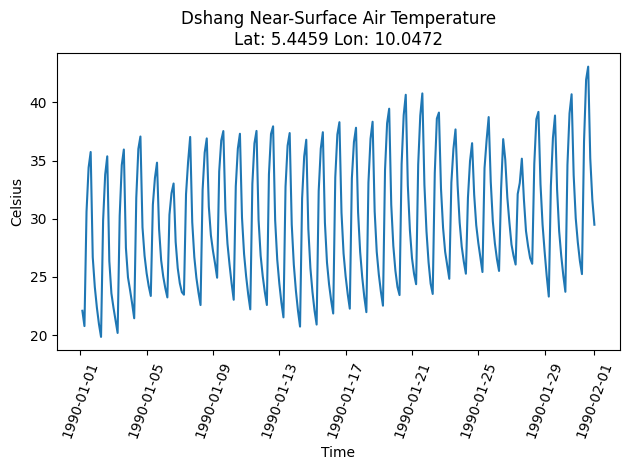

In [35]:
places = ({ 'lon' : 10.0472,
            'lat' : 5.4459,
            'name' : 'Dshang',
          },
         )

ncfile = Dataset(fname,'r')

lats = ncfile.variables['xlat'][:]
lons = ncfile.variables['xlon'][:]
vtime = ncfile.variables['time']
xtime = vtime[:]
times = num2pydate(xtime, units=vtime.units, calendar=vtime.calendar)

alat = None
alon = None

if lats.ndim == 1:
    alon,alat = np.meshgrid(lons,lats)
else:
    alat = lats
    alon = lons

for p in places:
    xlat = np.array((p['lon'],),np.float64)
    xlon = np.array((p['lat'],),np.float64)
    dd = get_distances(alat,alon,xlat,xlon)
    # Return nearest point.
    [jj,ii] = np.unravel_index(dd.argmin(), dd.shape)
    xt = ncfile.variables[vname]
    temp = xt[:,0,jj,ii]
    header='# Point latitude='+str(alat[jj,ii])+', longitude='+str(alon[jj,ii])
    print(header)
    header='#      Time            temperature ('+ncfile.variables['tas'].units+')'
    print(header)
    for i in range(len(xtime)):
        print(times[i].strftime('%Y-%m-%dT%H:%M:%SZ')+' {0:8.2f}'.format(temp[i]))
    plt.figure( )
    plt.plot(times,temp-273.15)
    plt.xlabel('Time')
    plt.ylabel('Celsius')
    plt.title(p['name']+" "+ncfile.variables[vname].long_name+"\nLat: "+str(p['lat'])+
              " Lon: "+str(p['lon']))
    plt.xticks(rotation=70)
    plt.tight_layout( )
ncfile.close()